# Unshuffling Experiments

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from fastai.vision import *
import torch
import torchvision.transforms

In [4]:
torch.cuda.set_device(1)

In [5]:
from PixelShuffle import *

In [29]:
class SoftPermutation(torch.nn.Module):
    """Permutes images"""
    def __init__(self, n, init_method, **kwargs):
        super(SoftPermutation, self).__init__()
        self.n = n
        self.permMatrix = torch.nn.Linear(n, n)
        if init_method.lower() == 'identity':
            self.permMatrix.weight.data = torch.eye(n)
        elif init_method.lower() == 'solution':
            self.permMatrix.weight.data = kwargs['data'].transpose(0,1)
        else:
            raise ValueError(f"Init method unrecognized: {init_method}")
    
    def forward(self, x):
        """Performs forward on normal NxCxHxW image tensors"""
        shape = x.shape
        x = torch.reshape(x, (shape[0], shape[1], self.n))
        x = self.permMatrix(x)
        x = torch.reshape(x, shape)
        return x
    
class StackedUnshuffler(torch.nn.Module):
    def __init__(self, n, learnedModel, init_method, **kwargs):
        super(StackedUnshuffler, self).__init__()
        self.permutation = SoftPermutation(n, init_method, **kwargs)
        self.learnedModel = learnedModel
    
    def forward(self, x):
        x = self.permutation(x)
        x = self.learnedModel(x)
        return x
    
    def freeze_model(self):
        c = 0
        for p in self.learnedModel.parameters():
            c += 1
            p.requires_grad = False
        print(f"Froze {c} parameters")

Visualizing the solution permutation matrix

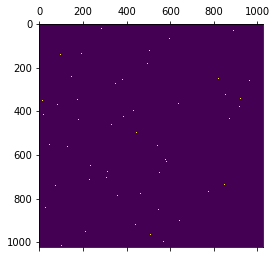

In [30]:
data, cifarShuffle = get_data_with_tfm(32, 128)
plt.matshow(cifarShuffle.createUnPermuteData())

Load learned model

In [98]:
learnedModel = models.wrn_22()
learnedModel.load_state_dict(torch.load('wrn22_pyramid_cycle'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Create unshuffled model arch

In [99]:
experiment_arch = StackedUnshuffler(32*32, learnedModel, 'solution', data=cifarShuffle.createUnPermuteData())

In [100]:
experiment_learner = Learner(data, experiment_arch, metrics=[accuracy])
# Create layer groups that we can use to freeze the model
experiment_learner.split(lambda m:(m.learnedModel,))
experiment_learner.freeze_to(2)
experiment_learner.summary()

StackedUnshuffler
Layer (type)         Output Shape         Param #    Trainable 
Linear               [3, 1024]            1,049,600  False     
______________________________________________________________________
Conv2d               [16, 32, 32]         432        False     
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
Conv2d               [96, 32, 32]         13,824     False     
______________________________________________________________________
BatchNorm2d          [96, 32, 32]         192        True      
______________________________________________________________________
ReLU                 [96, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [96, 32, 32]         82,944     False     
____________________________________________

In [101]:
preds, y, loss = experiment_learner.get_preds(with_loss=True)

In [102]:
accuracy(preds, y)

tensor(0.9033)

For comparison: here are WRN22's performances

| Dataset | Accuracy |
|---------|---------------------------|
| Unshuffled | 0.9075 |
| Shuffled | 0.9073 |

Accuracy w/ solution on shuffled: 0.9050

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


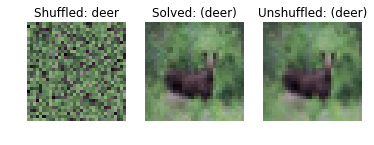

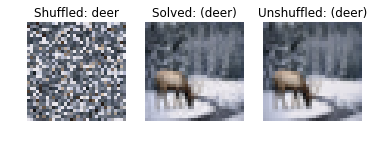

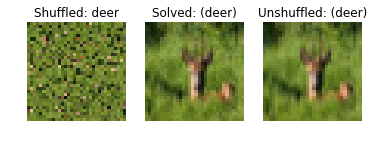

In [103]:
def visualizeIdxRange(givenRange):
    for i in givenRange:
        unshuffledImg, unshuffledLbl = cifarUnshuffledData.train_ds[i]
        shuffledImg, shuffledLbl = data.train_ds[i]

        def quick_pred(image, layer="learned"):
            model = experiment_learner.model.learnedModel
            if layer.lower() == "perm":
                model = experiment_learner.model.permutation
            pred = model(image.data.unsqueeze(0).cuda())
            if layer.lower() == "perm":
                return pred.detach()
            return pred.argmax()

        fig, axes = plt.subplots(1,3)
        top = axes
        shuffledImg.show(top[0])
        solvedImgData = quick_pred(shuffledImg, layer="perm").squeeze()
        solvedImg = Image(solvedImgData)
        predictedLbl = data.train_ds.y.reconstruct(quick_pred(solvedImg))
        predictedLbl2 = cifarUnshuffledData.train_ds.y.reconstruct(quick_pred(unshuffledImg))
        solvedImg.show(top[1])
        unshuffledImg.show(top[2])
        top[0].set_title(f"Shuffled: {shuffledLbl}")
        top[1].set_title(f"Solved: ({predictedLbl})")
        top[2].set_title(f"Unshuffled: ({predictedLbl2})")
visualizeIdxRange(range(20000,20003))

# Experiment Results:

| Method | Training Process | Accuracy |
| ------ | -------- |
| Unshuffler+FrozenTrainedWRN22 | 30 epochs | ? |
| Unshuffler+TrainedWRN22 | ? | ? |


In [109]:
experiment_learner.layer_groups[0].requires_grad = True

In [110]:
experiment_learner.fit(30, callbacks=[BnFreeze(experiment_learner)])

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.004716,0.582886,0.900400,00:42
0,0.004716,0.582886,0.900400,00:42


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


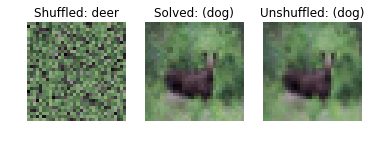

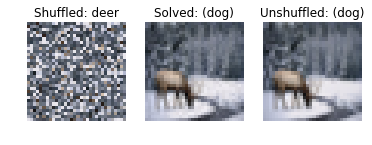

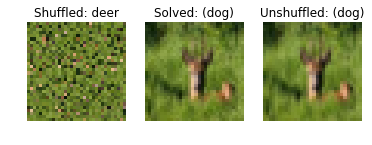

In [111]:
visualizeIdxRange(range(20000,20003))

In [112]:
preds, y, loss = experiment_learner.get_preds(with_loss=True)

In [113]:
accuracy(preds, y)

tensor(0.8474)

In [114]:
experiment_learner.model.learnedModel

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): BasicBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1):

In [115]:
unshuffledData = get_data(32, 128, with_shuffle=False)
unshuffledModel = Learner(unshuffledData, experiment_learner.model.learnedModel)

In [116]:
ps, ys = unshuffledModel.get_preds()

In [117]:
accuracy(ps, ys)

tensor(0.8440)